pixel&weight, multilinear regression

In [ ]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import datasets
import pandas as pd
%matplotlib inline
import io
import json
import csv
import os
from google.colab.patches import cv2_imshow
from PIL import Image
import cv2

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/뱀장어 평균 중량인식 공모전/data/dataset')

Mounted at /content/drive


In [ ]:
# train 폴더목록 불러오기
folder_list = os.listdir('./train')
folder_list.sort()

#'한 영상 안에서의 뱀장어의 평균 pixel개수' list
pxnum_video=[]
Area_list_video=[]
# train 폴더 내 json파일 목록 불러오기
for folder in folder_list:
  path = './train/' + folder
  train_folder_list = os.listdir(path)
  train_folder_list.sort()

  # jpg 파일만 불러오기
  jpg_file_list = [file for file in train_folder_list if file.endswith('.jpg')]
  # json 파일만 불러오기
  json_file_list = [file for file in train_folder_list if file.endswith('.json')]

  dict = {}
  #'한 jpg파일 안의 뱀장어 n마리의 평균 pixel개수' list
  pxnum_jpg=[]
  Area_list_json=[]
  # json 파일의 폴리곤 데이터값을 dict로 불러오기
  for json_file in json_file_list:
    with open((path + '/' + json_file),'r') as f:
      dict = json.load(f)

    #'한 json파일 안에서 선별된 뱀장어 n마리의 각각의 pixel개수' list
    pxnum_n = []
    Area_list_n = []
    for poly_num in range(len(dict['data'])):
      # 폴리곤 좌표 이용하여 넓이 구하기
      x_point = dict['data'][poly_num]['x']
      y_point = dict['data'][poly_num]['y']

      def PolyArea(x_point,y_point):
        return 0.5*np.abs(np.dot(x_point,np.roll(y_point,1))-np.dot(y_point,np.roll(x_point,1)))

      #area 구하기
      area=PolyArea(x_point,y_point)
      Area_list_n.append(area)
      Area=int(area)
      #json파일에 해당하는 이미지 불러오기
      jsonnumber=json_file.rstrip('.json')
      img = Image.open(path+'/'+jsonnumber+".jpg")
      #그 area만큼 같은 이미지를 crop하기. 
      croppedimg=img.crop((0,0,Area,1)) 
      #그 area만큼의 pixel개수 구하기
      img_size_cropped = croppedimg.size
      pxnum=img_size_cropped[0]*img_size_cropped[1]
      pxnum_n.append(pxnum)
    avg_pxnum_n = sum(pxnum_n)/len(pxnum_n)
    pxnum_jpg.append(avg_pxnum_n)
    avg_area_n = sum(Area_list_n)/len(Area_list_n)
    Area_list_json.append(avg_area_n)
  avg_pxnum_jpg = sum(pxnum_jpg)/len(pxnum_jpg)
  pxnum_video.append(avg_pxnum_jpg)
  avg_area_json = sum(Area_list_json)/len(Area_list_json)
  Area_list_video.append(avg_area_json)

In [ ]:
px_list_video=[x**1.5 for x in pxnum_video]
volumn_list_video=[x**1.5 for x in Area_list_video]

train 124개 폴더의 평균 중량값 얻기

In [ ]:
train_csv = pd.read_csv('./train.csv')
#train_csv 정렬
train_csv=train_csv.sort_values(by='ImageDir', ascending=True)

In [ ]:
AvgWeight = train_csv.loc[:, 'AvgWeight']
AvgWeight

19     72.089286
117    95.033696
8      27.564475
60     45.250000
110    21.020000
         ...    
24     55.283333
123    27.598478
44     47.373636
120    28.102391
29     27.009400
Name: AvgWeight, Length: 124, dtype: float64

산점도 그리기

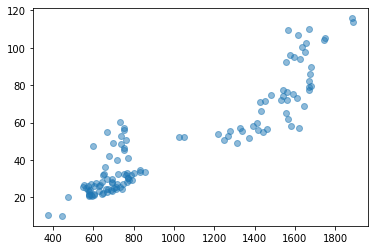

In [ ]:
pxnum = torch.Tensor(pxnum_video)
Weight = torch.Tensor(AvgWeight)
x_train = pxnum  # X for model training
x_train = x_train.reshape(-1,1)
y_train = Weight   # y label

plt.scatter(x_train, y_train, alpha=0.5)

model import

In [ ]:
data = {'x1_train' : Area_list_video,  
       'x2_train' : volumn_list_video,
       'x3_train' : pxnum_video,
       'x4_train' : px_list_video,
       'y_train' : AvgWeight}

data = pd.DataFrame(data)                 

x_train = data[['x1_train', 'x2_train','x3_train','x4_train']]
y_train = data[['y_train']]

가중치 a :  [[-24.93737866   0.29834049  24.87210899  -0.29598402]]
y절편 :  [39.14361846]
결정계수 :  0.8425887643307314


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


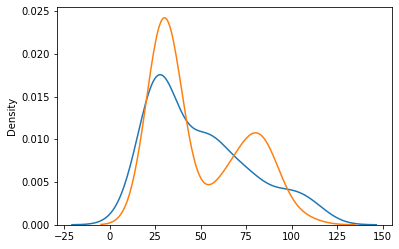

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(x_train, y_train)

y_p = lm.predict(x_train)

#가중치와 y절편 출력
print('가중치 a : ', lm.coef_)
print('y절편 : ', lm.intercept_)

#결정계수
relation_square = lm.score(x_train, y_train)
print('결정계수 : ', relation_square)

#seaborn으로 나타내기
import seaborn as sns
ax1 = sns.distplot(y_train, hist = False, label = 'y실제')
ax2 = sns.distplot(y_p, hist = False, label = 'y예측')
plt.show()

x_test만들기

In [ ]:
# test 폴더목록 불러오기
folder_list = os.listdir('./test')
folder_list.sort()

#'한 영상 안에서의 뱀장어의 평균 pixel개수' list
pxnum_video=[]
Area_list_video=[]
# train 폴더 내 json파일 목록 불러오기
for folder in folder_list:
  path = './test/' + folder
  test_folder_list = os.listdir(path)
  test_folder_list.sort()

  # jpg 파일만 불러오기
  jpg_file_list = [file for file in test_folder_list if file.endswith('.jpg')]
  # json 파일만 불러오기
  json_file_list = [file for file in test_folder_list if file.endswith('.json')]

  dict = {}
  #'한 jpg파일 안의 뱀장어 n마리의 평균 pixel개수' list
  pxnum_jpg=[]
  Area_list_json=[]
  # json 파일의 폴리곤 데이터값을 dict로 불러오기
  for json_file in json_file_list:
    with open((path + '/' + json_file),'r') as f:
      dict = json.load(f)
      #print(dict)

    #'한 json파일 안에서 선별된 뱀장어 n마리의 각각의 pixel개수' list
    pxnum_n = []
    Area_list_n = []
    for poly_num in range(len(dict['data'])):
      # 폴리곤 좌표 이용하여 넓이 구하기
      x_point = dict['data'][poly_num]['x']
      y_point = dict['data'][poly_num]['y']

      def PolyArea(x_point,y_point):
        return 0.5*np.abs(np.dot(x_point,np.roll(y_point,1))-np.dot(y_point,np.roll(x_point,1)))

      #area 구하기
      area=PolyArea(x_point,y_point)
      Area_list_n.append(area)
      Area=int(area)
      #json파일에 해당하는 이미지 불러오기
      jsonnumber=json_file.rstrip('.json')
      img = Image.open(path+'/'+jsonnumber+".jpg")
      #그 area만큼 같은 이미지를 crop하기. 시작점은 중간, 너비는 넓이를 고려해서
      croppedimg=img.crop((0,0,Area,1))
      #그 area만큼의 pixel개수 구하기
      img_size_cropped = croppedimg.size
      pxnum=img_size_cropped[0]*img_size_cropped[1]
      pxnum_n.append(pxnum)
    avg_pxnum_n = sum(pxnum_n)/len(pxnum_n)
    pxnum_jpg.append(avg_pxnum_n)
    avg_area_n = sum(Area_list_n)/len(Area_list_n)
    Area_list_json.append(avg_area_n)
  avg_pxnum_jpg = sum(pxnum_jpg)/len(pxnum_jpg)
  pxnum_video.append(avg_pxnum_jpg)
  avg_area_json = sum(Area_list_json)/len(Area_list_json)
  Area_list_video.append(avg_area_json)

In [ ]:
px_list_video=[x**1.5 for x in pxnum_video]
volumn_list_video=[x**1.5 for x in Area_list_video]

In [ ]:
data = {'x1_test' : Area_list_video,  
       'x2_test' : volumn_list_video, 
        'x3_test' : pxnum_video,
       'x4_test' : px_list_video}

data = pd.DataFrame(data)                 

x_test = data[['x1_test', 'x2_test','x3_test','x4_test']]

예측하기

In [ ]:
predictions = lm.predict(x_test) 
predictions = predictions.flatten()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- x1_test
- x2_test
- x3_test
- x4_test
Feature names seen at fit time, yet now missing:
- x1_train
- x2_train
- x3_train
- x4_train

  warnings.warn(message, FutureWarning)


csv파일 만들기

In [ ]:
data = {'ImageDir':folder_list, 'AvgWeight':predictions}
df = pd.DataFrame(data)
df

,ImageDir,AvgWeight
0,1I2EkxetCZ,29.672747
1,31PsozUNAW,90.850870
2,3AT4ivS98X,31.724181
3,49UmJQBya0,29.463563
4,4SJmIOpm84,28.895480
...,...,...
80,xZQH4hLHot,29.545941
81,xwlBbazGdz,35.942952
82,ya75FdleJX,86.902019
83,yyYdnAwplY,85.685872


In [ ]:
csv_path = '/content/drive/MyDrive/뱀장어'
df.to_csv(csv_path+'/test.csv')